<a href="https://colab.research.google.com/github/NyafeuKamdem/retail_demand_forcasting/blob/main/XGBoost_demand_forecast_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install darts

###**Import packages**

In [2]:
# Importing the needed packages.
import numpy as np                                                # For numerical operation arraywise.
import pandas as pd                                               # For Data manipulation.
import matplotlib.pyplot as plt                                   # For basic visualization's functions.
import seaborn as sns                                             # For advance visualization's functions.
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

from darts import TimeSeries
from darts.models import ARIMA
import xgboost as xgb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pwd  # pwd = 'print working directory' tels us where we are

/content


In [4]:
%cd drive/MyDrive/ # cd = 'change directory'

[Errno 2] No such file or directory: 'drive/MyDrive/ # cd = change directory'
/content


In [5]:
!pwd

/content


###**Data Loading for Guayas Region**

In [6]:
df = pd.read_csv('/content/drive/MyDrive/guayas_ready.csv', index_col=0) # index_col=0 let pandas know that the df has an index

In [7]:
df.shape

(23403660, 12)

In [8]:
df.head(1)

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,z_score,unit_sales_log,year,month,day,day_of_week
0,2013-01-09,302230,24,96995,2.0,False,0.053571,1.098612,2013,1,9,2


In [9]:
# Filtering the dataset for the perioid of Jan 1 – Mar 31 2014
#min_date = '2013-12-31'
max_date = '2014-04-01'
df = df[(df['date'] < max_date)]
df.shape

(4155315, 12)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4155315 entries, 0 to 88
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   id              int64  
 2   store_nbr       int64  
 3   item_nbr        int64  
 4   unit_sales      float64
 5   onpromotion     object 
 6   z_score         float64
 7   unit_sales_log  float64
 8   year            int64  
 9   month           int64  
 10  day             int64  
 11  day_of_week     int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 412.1+ MB


###**EDA**

####**Handling Missing data**

In [11]:
df.isna().sum()

,0
date,0
id,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,0
z_score,11
unit_sales_log,0
year,0
month,0


In [12]:
df = df.dropna(subset=['z_score'])

In [13]:
df.isna().sum()

,0
date,0
id,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,0
z_score,0
unit_sales_log,0
year,0
month,0


####**Feature Engineering for Machine Learning**

In [14]:
df.head(1)

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,z_score,unit_sales_log,year,month,day,day_of_week
0,2013-01-09,302230,24,96995,2.0,False,0.053571,1.098612,2013,1,9,2


In [15]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()

In [16]:
df.head(1)

,id,store_nbr,item_nbr,unit_sales,onpromotion,z_score,unit_sales_log,year,month,day,day_of_week
date,,,,,,,,,,,
2013-01-02,26865,35,598414,9.0,False,1.245204,2.302585,2013,1,2,2


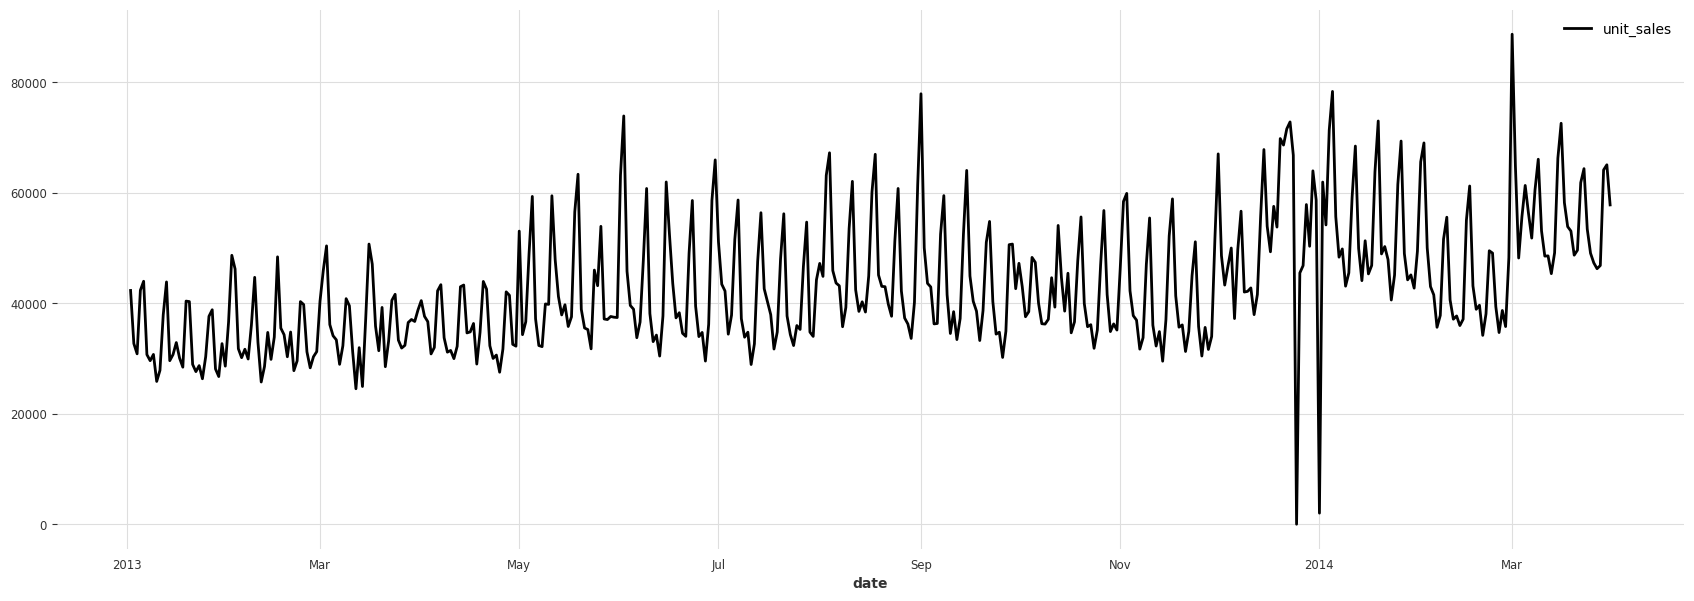

In [17]:
# Group by date and aggregate sales for each day
df_dayly = df.groupby('date').sum()['unit_sales'].reset_index()

# Fill missing dates with zero sales (since some dates may have no sales)
df_dayly = df_dayly.set_index('date')
df_dayly = df_dayly.asfreq('D').fillna(0)

# Convert to a Darts TimeSeries object
series = TimeSeries.from_dataframe(df_dayly, value_cols='unit_sales')

# Visualize the filtered sales data
plt.figure(figsize=(21, 7))  # Adjust the figure size (width, height)
series.plot()
plt.show()

In [18]:
# Create lag features (sales from the previous day, previous week)
df_dayly['lag_1'] = df_dayly['unit_sales'].shift(1)
df_dayly['lag_7'] = df_dayly['unit_sales'].shift(7)
df_dayly['lag_30'] = df_dayly['unit_sales'].shift(30)

# Drop any rows with NaN values after creating lag features
df_dayly = df_dayly.dropna()

In [25]:
df_dayly.head(8)

,unit_sales,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7
date,,,,,,
2013-02-08,36084.0,29912.0,36573.0,30738.0,36427.857143,7874.101651
2013-02-09,44700.0,36084.0,48688.0,25852.0,36358.000000,7874.768483
2013-02-10,32938.0,44700.0,46210.0,27864.0,35788.285714,6920.499927
2013-02-11,25749.0,32938.0,31774.0,37915.0,33892.285714,5191.470624
2013-02-12,28542.0,25749.0,30152.0,43867.0,33031.571429,6032.528045
2013-02-13,34728.0,28542.0,31686.0,29611.0,32801.571429,6189.270120
2013-02-14,29846.0,34728.0,29912.0,30722.0,33236.142857,6204.662882
2013-02-15,33877.0,29846.0,36084.0,32890.0,33226.714286,6210.603425


In [20]:
# Create rolling mean and rolling standard deviation features.
# We need to shift by one before rolling so only past data are used.
df_dayly['rolling_mean_7'] = df_dayly['unit_sales'].shift(1).rolling(window=7).mean()
df_dayly['rolling_std_7'] = df_dayly['unit_sales'].shift(1).rolling(window=7).std()

# Drop any NaN values after creating rolling features
df_dayly.dropna(inplace=True)

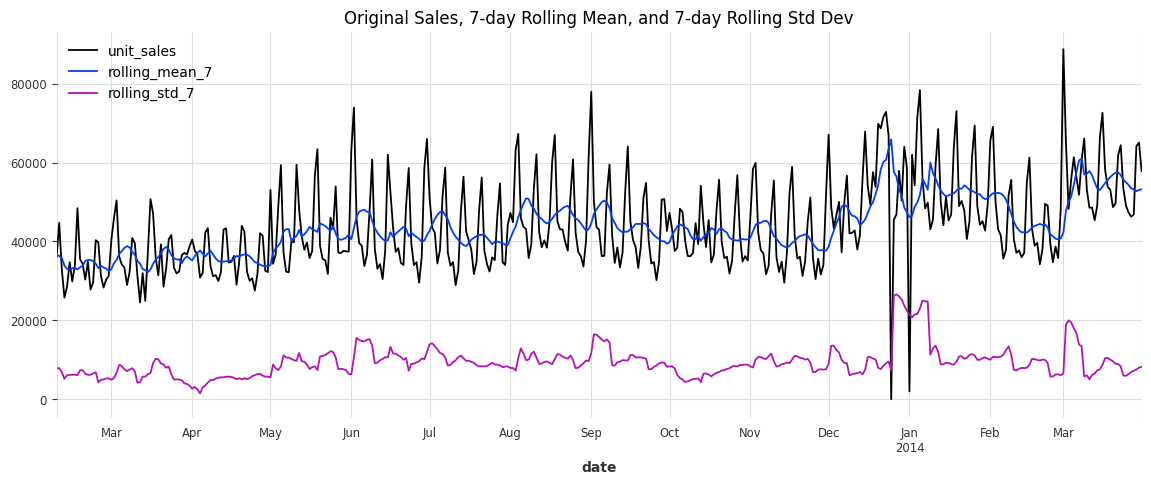

In [21]:
# Visualize the new features alongside the original sales
df_dayly[['unit_sales', 'rolling_mean_7', 'rolling_std_7']].plot(figsize=(14, 5))
plt.title('Original Sales, 7-day Rolling Mean, and 7-day Rolling Std Dev')
plt.show()

In [23]:
df_dayly.shape

(417, 6)

In [28]:
# Add date-based features
df_dayly['day'] = df_dayly.index.day
df_dayly['day_of_week'] = df_dayly.index.dayofweek
df_dayly['is_weekend'] = df_dayly['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df_dayly['month'] = df_dayly.index.month

In [29]:
df_dayly.head()

,unit_sales,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7,day,day_of_week,is_weekend,month
date,,,,,,,,,,
2013-02-08,36084.0,29912.0,36573.0,30738.0,36427.857143,7874.101651,8,4,0,2
2013-02-09,44700.0,36084.0,48688.0,25852.0,36358.000000,7874.768483,9,5,1,2
2013-02-10,32938.0,44700.0,46210.0,27864.0,35788.285714,6920.499927,10,6,1,2
2013-02-11,25749.0,32938.0,31774.0,37915.0,33892.285714,5191.470624,11,0,0,2
2013-02-12,28542.0,25749.0,30152.0,43867.0,33031.571429,6032.528045,12,1,0,2


###**Model**

####**Data Splitting**

In [32]:
len(df_dayly.index)

417

In [42]:
a = df_dayly.copy()[(df_dayly.index < '2014-03-01') & (df_dayly.index > '2013-12-31')]
a.shape

(59, 10)

In [39]:
a.index.max()

Timestamp('2014-02-28 00:00:00')

In [44]:
# Define a min and cutoff date for training vs. testing
min_date = '2014-01-01'      #   the starting date
cutoff_date = '2014-03-01'  #   train = Jan–Feb, test = March

# Split the DataFrame chronologically
train = df_dayly[(df_dayly.index >= min_date) & (df_dayly.index < cutoff_date)]
test  = df_dayly[df_dayly.index >= cutoff_date]

# Define features and target
X_train = train.drop('unit_sales', axis=1)
y_train = train['unit_sales']

X_test  = test.drop('unit_sales', axis=1)
y_test  = test['unit_sales']

print("Training rows:", len(train))
print("Testing rows:", len(test))

Training rows: 59
Testing rows: 31


####**Implementing XGBoost for Time-Series Forecasting**

In [48]:
import xgboost as xgb

# Initialize XGBoost regressor
xgboost_model = xgb.XGBRegressor(
    n_estimators=100,       # number of trees
    learning_rate=0.1,      # step size shrinkage
    max_depth=6,            # max depth of each tree
    random_state=42
)


In [49]:
# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgboost_model.predict(X_test)

####**Plotting Actual vs Predicted Values and Metrics**

#####**Basic Model**

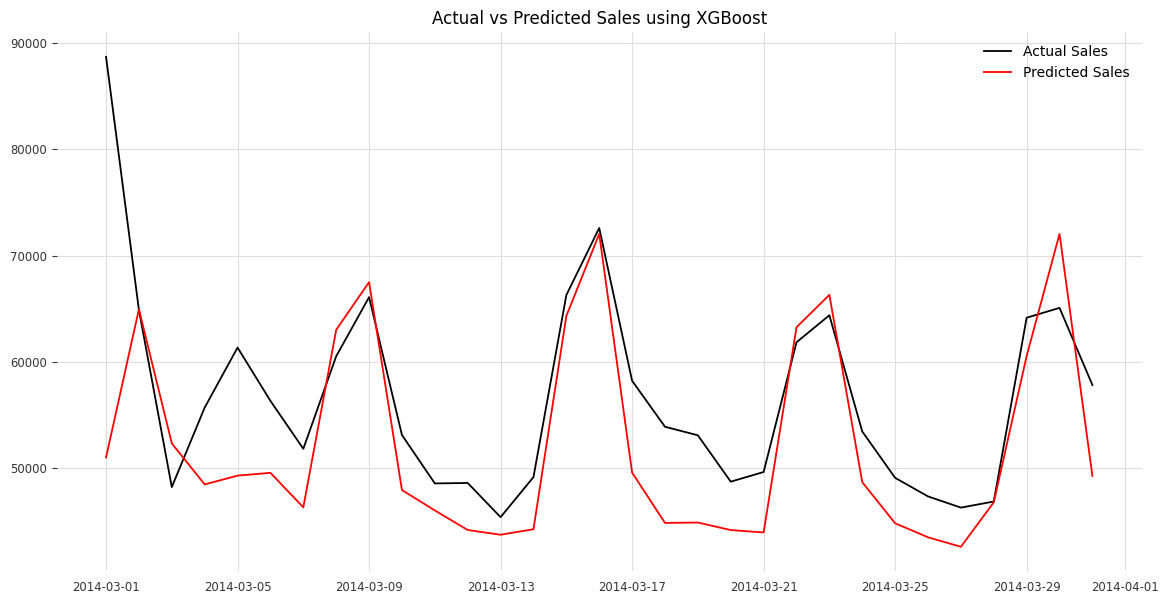

In [50]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test.values, label='Actual Sales')
plt.plot(y_test.index, y_pred, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

In [51]:
# 4. Metrics
# y_test and y_pred are Pandas Series aligned by date
from sklearn.metrics import mean_absolute_error

mae  = mean_absolute_error(y_test, y_pred)

print(f"MAE : {mae:.3f} units")

MAE   : 5610.870 units
